In [218]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matrixprofile as mp
import random
import time
import os
from matplotlib.patches import Rectangle


In [12]:
path = '../verisetleri/TrafficLabelling /Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'
path_synflood = "../verisetleri/01-12/Syn.csv"

In [13]:
def upload_dataset_with_time(path:str):
    startingT = time.time()
    veriseti = pd.read_csv(path, low_memory=False)
    endingT = time.time()
    print(f"Dataset is loaded in {endingT - startingT} seconds")
    return veriseti

In [14]:
friday = upload_dataset_with_time(path)
syn_flood = upload_dataset_with_time(path_synflood)

Dataset is loaded in 2.6848278045654297 seconds
Dataset is loaded in 71.49943995475769 seconds


In [15]:
syn_by_minute = pd.DataFrame()
syn_by_minute["Time_Date"] = syn_flood[" Timestamp"].apply(lambda x : str(x).split(" ")[0])
syn_by_minute["Date_Second"] = syn_flood[" Timestamp"].apply(lambda x : str(x).split(" ")[1].split(".")[0])
syn_by_minute["Date_Hour_Minute"] = syn_flood[" Timestamp"].apply(lambda x: ":".join(str(x).split(" ")[1].split(":")[:2]))

In [16]:
syn_by_minute

,Time_Date,Date_Second,Date_Hour_Minute
0,2018-12-01,13:30:30,13:30
1,2018-12-01,13:30:30,13:30
2,2018-12-01,13:30:30,13:30
3,2018-12-01,13:30:30,13:30
4,2018-12-01,13:30:30,13:30
...,...,...,...
1582676,2018-12-01,13:34:27,13:34
1582677,2018-12-01,13:34:27,13:34
1582678,2018-12-01,13:34:27,13:34
1582679,2018-12-01,13:34:27,13:34


In [17]:
syn_by_minute_df = pd.concat([syn_by_minute, syn_flood.iloc[:,9: 50], syn_flood[" Label"]], axis = 1).reset_index(drop=True)

In [18]:
syn_by_minute_df["Label"] = syn_by_minute_df[" Label"].apply(lambda x: 1 if str(x) == "Syn" else 0)

In [19]:
syn_by_minute_df = syn_by_minute_df.drop(labels = [" Label"], axis = 1).copy()
syn_by_minute_df.head(5)

,Time_Date,Date_Second,Date_Hour_Minute,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,...,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Label
0,2018-12-01,13:30:30,13:30,19,2,0.0,0.0,0.0,0.0,0.0,...,380,40,1.640770e-01,0.017271,0.0,0.0,0.0,0.0,0.0,1
1,2018-12-01,13:30:30,13:30,16,0,0.0,0.0,0.0,0.0,0.0,...,320,0,1.403830e-01,0.000000,0.0,0.0,0.0,0.0,0.0,1
2,2018-12-01,13:30:30,13:30,2,2,0.0,0.0,0.0,0.0,0.0,...,40,40,1.785714e+04,17857.142857,0.0,0.0,0.0,0.0,0.0,1
3,2018-12-01,13:30:30,13:30,16,0,0.0,0.0,0.0,0.0,0.0,...,320,0,1.509648e-01,0.000000,0.0,0.0,0.0,0.0,0.0,1
4,2018-12-01,13:30:30,13:30,2,0,0.0,0.0,0.0,0.0,0.0,...,40,0,2.000000e+06,0.000000,0.0,0.0,0.0,0.0,0.0,1


In [20]:
unique_seconds = set(syn_by_minute_df["Date_Second"])
print(f"length of unique minutes: {len(unique_seconds)}")

length of unique minutes: 238


In [21]:
cols = syn_by_minute_df.columns
df = dict()
length_of_a_second = []
for idx, minute in enumerate(unique_seconds):
    second_df = dict()
    minute_syn = syn_by_minute_df[syn_by_minute_df["Date_Second"] == minute]
    for col in cols:
        try:
            second_df[col] = sum(minute_syn[col])
            length_of_a_second.append(len(minute_syn[col]))
        except:
            pass
    df[minute] = second_df

In [22]:
aggregate_seconds_df = pd.DataFrame(df).transpose()

In [23]:
from collections import Counter
sec_counter = Counter(length_of_a_second)
sorted_sec_dict = dict(sorted(dict(sec_counter).items(), key = lambda x:x[1], reverse=True))

In [24]:
average = 0
for sec, count in dict(sorted_sec_dict).items():
    average += int(sec) * int(count)

print(f"avg samples for a second: {average / sum(sorted_sec_dict.values())}")

avg samples for a second: 6649.920168067227


In [25]:
path_udp_lag = '../verisetleri/01-12/DrDoS_NTP.csv'
udp_lag = upload_dataset_with_time(path_udp_lag)

Dataset is loaded in 43.95187592506409 seconds


In [26]:
benign_data = udp_lag[udp_lag[" Label"] == 'BENIGN'].reset_index(drop=True)
new_df_cols = list(aggregate_seconds_df.columns)
new_df_cols.remove("Label")
new_df_cols.append(" Label")
new_df_cols.append(" Timestamp")

In [27]:
benign_data = benign_data[[*new_df_cols]]
benign_data["Label"] = benign_data[" Label"].apply(lambda x: 0)
benign_data.drop([" Label"], axis = 1, inplace=True)
b_sec_1 = benign_data.iloc[:6000, :].reset_index(drop = True)
b_sec_2 = benign_data.iloc[6000:12000, :].reset_index(drop = True)
b_sec_3 = pd.concat(objs=[benign_data.iloc[12000:14000, :], benign_data.iloc[4000:8000, :]], axis=0).reset_index(drop=True)


In [28]:
b_secs = [b_sec_1, b_sec_2, b_sec_3]
df = dict()
for (idx, b_sec) in enumerate(b_secs):
    
    second_df = dict()
    for col in b_sec.columns:
        try:
            second_df[col] = sum(b_sec[col])
        except:
            pass

    df[idx] = second_df

benign_seconds_df = pd.DataFrame(df).transpose()
    

In [29]:
benign_df = pd.DataFrame()
for idx in range(0,60*20): # twenty minutes
    benign_df = pd.concat(objs=[benign_df, benign_seconds_df], axis = 0).reset_index(drop=True)

In [30]:
df = pd.DataFrame()
df = pd.concat(objs=[benign_df, benign_df, aggregate_seconds_df, benign_df, benign_df, benign_df, aggregate_seconds_df, benign_df, benign_df], axis = 0).reset_index(drop=True)

In [31]:
df

,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Label
0,48909.0,72193.0,5278085.0,138620706.0,1090202.0,104099.0,283164.406577,313470.988649,3213141.0,260504.0,...,1.003700e+06,1.523404e+06,7.184094e+08,3.907212e+07,99474.0,3394840.0,610452.099664,795468.719934,9.985600e+08,0.0
1,39524.0,36679.0,3508037.0,15398436.0,771278.0,110393.0,227406.836426,210941.501413,1933882.0,249326.0,...,8.039800e+05,8.288560e+05,7.930575e+08,1.786188e+07,107214.0,2063759.0,436648.922880,530980.392343,3.077283e+08,0.0
2,34521.0,31317.0,3365823.0,12264572.0,755249.0,98726.0,232068.791277,220896.861116,1718078.0,221093.0,...,-2.550454e+10,-2.550455e+10,1.127396e+09,1.957448e+07,94632.0,1893322.0,417656.758716,505439.642372,2.923933e+08,0.0
3,48909.0,72193.0,5278085.0,138620706.0,1090202.0,104099.0,283164.406577,313470.988649,3213141.0,260504.0,...,1.003700e+06,1.523404e+06,7.184094e+08,3.907212e+07,99474.0,3394840.0,610452.099664,795468.719934,9.985600e+08,0.0
4,39524.0,36679.0,3508037.0,15398436.0,771278.0,110393.0,227406.836426,210941.501413,1933882.0,249326.0,...,8.039800e+05,8.288560e+05,7.930575e+08,1.786188e+07,107214.0,2063759.0,436648.922880,530980.392343,3.077283e+08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25671,39524.0,36679.0,3508037.0,15398436.0,771278.0,110393.0,227406.836426,210941.501413,1933882.0,249326.0,...,8.039800e+05,8.288560e+05,7.930575e+08,1.786188e+07,107214.0,2063759.0,436648.922880,530980.392343,3.077283e+08,0.0
25672,34521.0,31317.0,3365823.0,12264572.0,755249.0,98726.0,232068.791277,220896.861116,1718078.0,221093.0,...,-2.550454e+10,-2.550455e+10,1.127396e+09,1.957448e+07,94632.0,1893322.0,417656.758716,505439.642372,2.923933e+08,0.0
25673,48909.0,72193.0,5278085.0,138620706.0,1090202.0,104099.0,283164.406577,313470.988649,3213141.0,260504.0,...,1.003700e+06,1.523404e+06,7.184094e+08,3.907212e+07,99474.0,3394840.0,610452.099664,795468.719934,9.985600e+08,0.0
25674,39524.0,36679.0,3508037.0,15398436.0,771278.0,110393.0,227406.836426,210941.501413,1933882.0,249326.0,...,8.039800e+05,8.288560e+05,7.930575e+08,1.786188e+07,107214.0,2063759.0,436648.922880,530980.392343,3.077283e+08,0.0


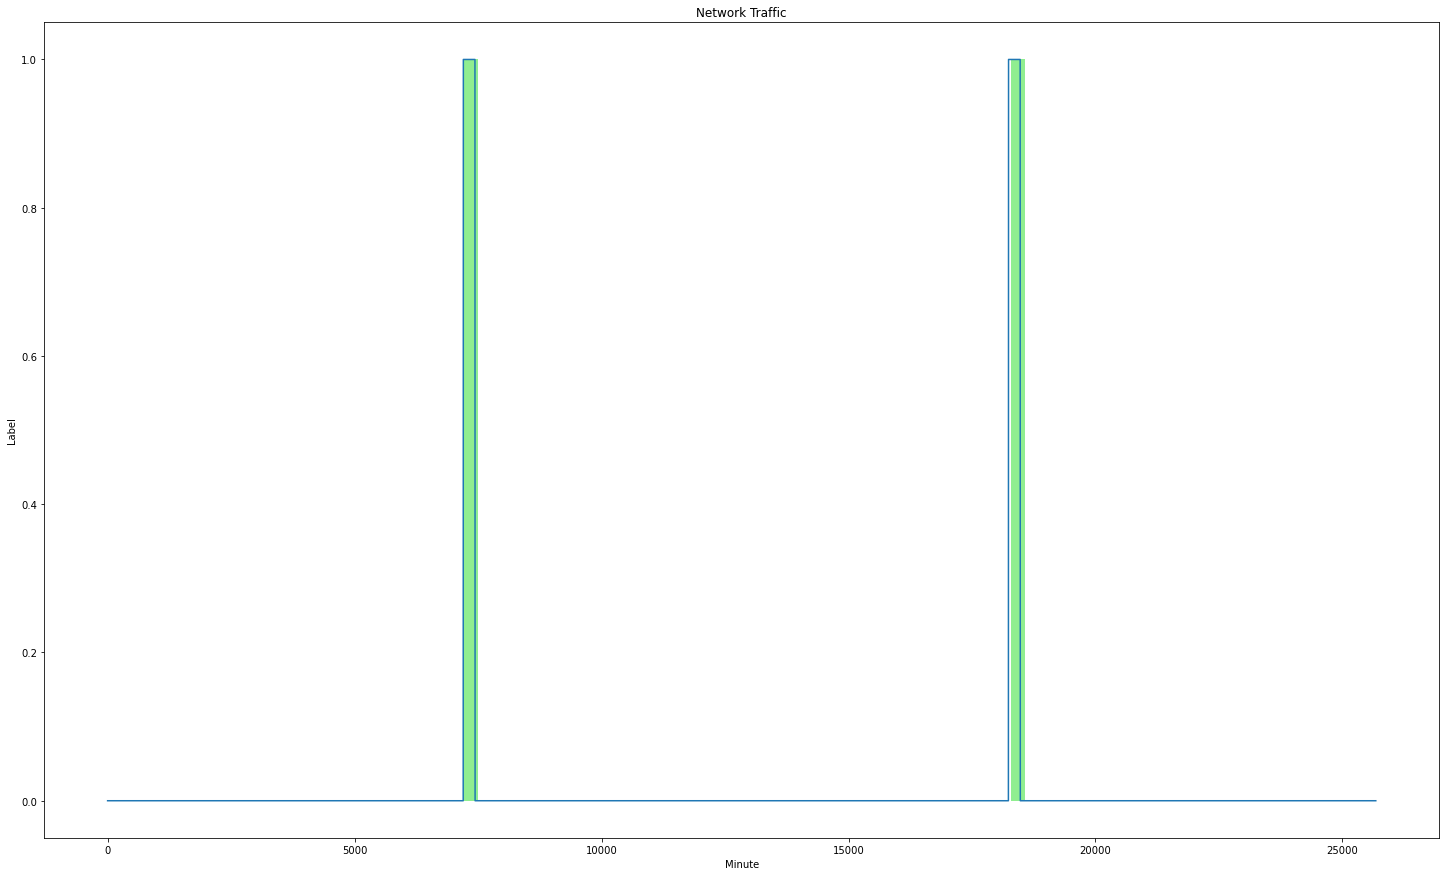

In [60]:
xAxis = list(range(len(df)))
yAxis = df["Label"].to_list()
yLabels = [1 if lbl>50 else 0 for lbl in yAxis]
# Create a figure
fig = plt.figure(figsize=(25,15))
# Add a subplot
ax = fig.add_subplot()

ax.plot(xAxis, yLabels)
rect = Rectangle((7200, 0), 300, 1, facecolor='lightgreen')
ax.add_patch(rect)
rect = Rectangle((3600*3 + 7200 +280, 0), 300, 1, facecolor='lightgreen')
ax.add_patch(rect)
plt.ylabel('Label')
plt.xlabel('Minute')
plt.title('Network Traffic')
plt.show()

In [84]:
sorted(df.corr()["Label"].to_dict().items(), key=lambda x: abs(x[1]), reverse=True)[:10]

[(' Fwd Packet Length Min', -0.935861038006268),
 ('Fwd PSH Flags', -0.6785256572263891),
 (' Bwd PSH Flags', nan),
 (' Fwd URG Flags', nan),
 (' Bwd URG Flags', nan),
 ('Label', 1.0),
 ('Fwd Packets/s', 0.9664928508525789),
 (' Min Packet Length', -0.9228832723300677),
 (' Bwd Packet Length Min', -0.883169278888756),
 (' Bwd IAT Min', -0.881588334294873)]

In [62]:
def calculate_matrix_profile(featureName:str, dataframe:pd.DataFrame, window_size:int=5, threshold_:float=0.95, n_jobs_:int=4):
    startingTime = time.time()
    featureForTimeSeries : list = dataframe[featureName].to_list()
    matrix_profile = mp.compute(featureForTimeSeries, windows=window_size, threshold=threshold_, n_jobs=n_jobs_)
    endingTime = time.time()
    
    print(f"matrix profile calculation takes {endingTime - startingTime} seconds")
    return matrix_profile


def calculate_motifs(matrix_profile,  motif_num, max_neighbours):
    motif_profile = mp.discover.motifs(matrix_profile, exclusion_zone=5, k=motif_num, max_neighbors=max_neighbours)
    return motif_profile

def calculate_discords(matrix_profile, discord_number, exclusion_zone):
    discord_profile = mp.discover.discords(profile=matrix_profile, exclusion_zone=exclusion_zone, k=discord_number)
    return discord_profile


    

In [219]:
window_size = 60
threshold_ = 0.0
motif_number = 4
discord_number = 100
n_jobs_ = 4
my_data = df.copy()
feature_name = " Bwd Packet Length Min"
m_exclusion = int(np.ceil(window_size/4))



matrix_profile = calculate_matrix_profile(featureName=feature_name, dataframe=my_data, window_size=window_size)
# motif_profile = calculate_motifs(matrix_profile=matrix_profile, motif_num=motif_number, max_neighbours=6)
# matrix_profile["mp"] = matrix_profile["mp"][m_exclusion:len(matrix_profile["mp"])-m_exclusion]
discord_profile = calculate_discords(matrix_profile=matrix_profile, exclusion_zone=m_exclusion, discord_number=discord_number)

matrix profile calculation takes 0.3338761329650879 seconds


/Users/batuhanduyuler/opt/anaconda3/lib/python3.8/site-packages/matrixprofile/visualize.py:375: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


[<Figure size 1080x504 with 2 Axes>, <Figure size 1080x504 with 4 Axes>]

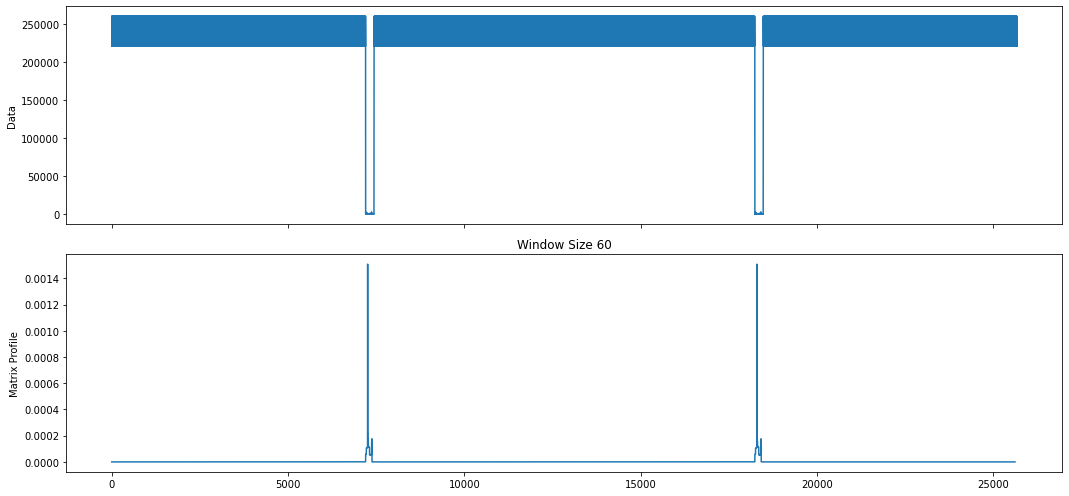

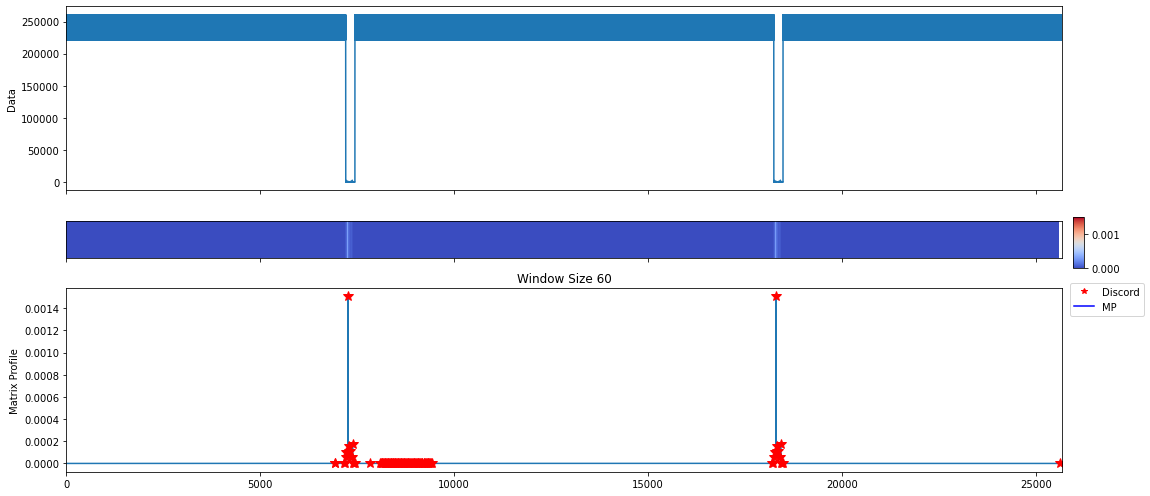

In [220]:
mp.visualize(profile=discord_profile)

In [221]:
def select_samples_from_dataset(dataset : pd.DataFrame , samples : list):
    if (dataset.empty):
        raise ValueError("Dataset is None!")

    if (samples == None):
        raise ValueError("sample list is None")

    sampled_data = list()
    for point in samples:
        sampled_data.append(dataset.iloc[point, :])

    return pd.DataFrame(sampled_data).reset_index()

In [222]:
discords_indexes = list(discord_profile["discords"])
discords_ranges = [range(discord_idx, discord_idx + window_size) for discord_idx in discords_indexes]
# discords_ranges

discord_predictions = select_samples_from_dataset(df, samples=discords_indexes)
discord_predictions.head(3)

,index,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Label
0,18294,11805.0,1240.0,1458.0,2834.0,440.0,0.0,69.428571,127.041557,976.0,...,236368.0,25128.0,7.063355e+09,1.566736e+07,0.0,976.0,89.416667,212.393236,45110.886525,5812.0
1,7258,12748.0,1288.0,480.0,0.0,240.0,240.0,240.000000,0.000000,0.0,...,254960.0,25760.0,7.821748e+09,1.647913e+07,240.0,240.0,240.000000,0.000000,0.000000,6337.0
2,18416,13024.0,1328.0,112.0,0.0,56.0,56.0,56.000000,0.000000,0.0,...,260520.0,26560.0,7.408248e+09,1.430691e+07,56.0,56.0,56.000000,0.000000,0.000000,5912.0


In [234]:
mp_sorted = np.argsort(discord_profile["mp"])[::-1][:500]
mp_sorted_predictions = select_samples_from_dataset(df, samples=list(mp_sorted))
mp_sorted_predictions.head(3)

,index,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Label
0,18294,11805.0,1240.0,1458.0,2834.0,440.0,0.0,69.428571,127.041557,976.0,...,236368.0,25128.0,7.063355e+09,1.566736e+07,0.0,976.0,89.416667,212.393236,45110.886525,5812.0
1,18296,12748.0,1288.0,480.0,0.0,240.0,240.0,240.000000,0.000000,0.0,...,254960.0,25760.0,7.821748e+09,1.647913e+07,240.0,240.0,240.000000,0.000000,0.000000,6337.0
2,18295,15522.0,1584.0,112.0,0.0,56.0,56.0,56.000000,0.000000,0.0,...,310440.0,31680.0,7.234690e+09,1.467172e+07,56.0,56.0,56.000000,0.000000,0.000000,6141.0


In [245]:
def calculate_accuracy(dataframe: pd.DataFrame, predictedLabel = 1):
    predictionNumber = len(dataframe)
    numberOfSelectedLabel = dataframe[dataframe["Label"].apply(lambda x : True if int(x) > 0 else False)]
    acc = len(numberOfSelectedLabel) / predictionNumber
    print(f"accuracy is : {acc}")

In [246]:
calculate_accuracy(mp_sorted_predictions)
calculate_accuracy(discord_predictions)

accuracy is : 0.886
accuracy is : 0.25


In [251]:
import stumpy
from stumpy import config

stumpy_df = df[["Fwd Packets/s", " Min Packet Length", " Bwd Packet Length Min", " Bwd IAT Min"]].reset_index(drop=True)

config.STUMPY_EXCL_ZONE_DENOM = 4  # The exclusion zone is i ± int(np.ceil(m / 4)) and is the same as the default setting
m = window_size
mps, indices = stumpy.mstump(stumpy_df, m, discords=True)
discords_idx = np.argmax(mps, axis=1)


In [252]:
mps[:, 0].shape

(4,)

In [253]:
mps_dict = dict()
mps_dict = {i: np.argsort(mps[i])[::-1][:500] for i in range(0, len(mps))}

In [261]:
idx_dict = dict()
for k, v in mps_dict.items():
    for idx in v:
        if idx in idx_dict.keys():
            idx_dict[idx] += 1
        else:
            idx_dict[idx] = 1

In [270]:
sorted_idx_dict = dict(sorted(idx_dict.items(), key=lambda x: x[1], reverse=True))
discords = list(sorted_idx_dict.keys())[:500]

In [271]:
multivariate_discords = select_samples_from_dataset(df, samples=discords)
multivariate_discords.head(4)

,index,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,Label
0,18295,15522.0,1584.0,112.0,0.0,56.0,56.0,56.000000,0.000000,0.0,...,310440.0,31680.0,7.234690e+09,1.467172e+07,56.0,56.0,56.000000,0.000000,0.000000,6141.0
1,7258,12748.0,1288.0,480.0,0.0,240.0,240.0,240.000000,0.000000,0.0,...,254960.0,25760.0,7.821748e+09,1.647913e+07,240.0,240.0,240.000000,0.000000,0.000000,6337.0
2,7257,15522.0,1584.0,112.0,0.0,56.0,56.0,56.000000,0.000000,0.0,...,310440.0,31680.0,7.234690e+09,1.467172e+07,56.0,56.0,56.000000,0.000000,0.000000,6141.0
3,7256,11805.0,1240.0,1458.0,2834.0,440.0,0.0,69.428571,127.041557,976.0,...,236368.0,25128.0,7.063355e+09,1.566736e+07,0.0,976.0,89.416667,212.393236,45110.886525,5812.0


In [272]:
calculate_accuracy(multivariate_discords)

accuracy is : 0.716


In [160]:
nn_idx = indices[np.arange(len(discords_idx)), discords_idx]
k = 4
S = stumpy.subspace(stumpy_df, m, discords_idx[k], nn_idx[k], k, discords=True)

In [63]:
nn_idx

array([18389, 18390, 18390, 18391, 18391])

In [66]:
df["Label"][nn_idx[:]]

18389    6790.0
18390    9087.0
18390    9087.0
18391    6561.0
18391    6561.0
Name: Label, dtype: float64

In [106]:
mp_df = pd.DataFrame(list(discord_profile["mp"]), columns=["MatrixProfile"])

In [175]:
steam_df = pd.read_csv("https://zenodo.org/record/4273921/files/STUMPY_Basics_steamgen.csv?download=1")
steam_df.head(3)

,drum pressure,excess oxygen,water level,steam flow
0,320.08239,2.506774,0.032701,9.302970
1,321.71099,2.545908,0.284799,9.662621
2,320.91331,2.360562,0.203652,10.990955


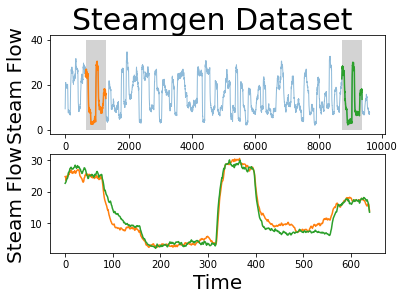

In [176]:
m = 640
fig, axs = plt.subplots(2)
plt.suptitle('Steamgen Dataset', fontsize='30')
axs[0].set_ylabel("Steam Flow", fontsize='20')
axs[0].plot(steam_df['steam flow'], alpha=0.5, linewidth=1)
axs[0].plot(steam_df['steam flow'].iloc[643:643+m])
axs[0].plot(steam_df['steam flow'].iloc[8724:8724+m])
rect = Rectangle((643, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((8724, 0), m, 40, facecolor='lightgrey')
axs[0].add_patch(rect)
axs[1].set_xlabel("Time", fontsize='20')
axs[1].set_ylabel("Steam Flow", fontsize='20')
axs[1].plot(steam_df['steam flow'].values[643:643+m], color='C1')
axs[1].plot(steam_df['steam flow'].values[8724:8724+m], color='C2')
plt.show()

In [177]:
m = 640
mp = stumpy.stump(steam_df['steam flow'], m)

In [198]:
motif_idx = np.argsort(mp[:, 0])[:2]

print(f"The motif is located at index {motif_idx}")

The motif is located at index [ 643 8724]


In [199]:
nearest_neighbor_idx = mp[motif_idx[0], 1]

print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

The nearest neighbor is located at index 8724


In [180]:
len(steam_df['steam flow'])

9600

### Matrix Profile 

In [5]:
import math
import numpy as np
time_series = list(range(0,100))
n = len(time_series)
m = 4 #window_size
print(f"seri uzunlugu: {n}")

seri uzunlugu: 100


In [6]:
D_m = list()
sub_sequence_num = n - m + 1
for i in range(0, sub_sequence_num):
    pair_i = time_series[i:i+m]
    D_i = list()
    for j in range(0, sub_sequence_num):
        pair_j = time_series[j:j+m]
        D_j = np.sqrt(sum((np.array(pair_i) - np.array(pair_j))**2))
        D_i.append(D_j)
    D_m.append(D_i)

In [8]:
np.array(D_m).shape

(97, 97)

In [3]:
for i in range(n-m+1):
    for j in range(n-m+1):
        D = 0
        for k in range(m):
            D += (time_series[i+k] - time_series[j+k])**2
        D = math.sqrt(D)

In [4]:
D

0.0